<a href="https://colab.research.google.com/github/rmontenegroo/discursos/blob/main/nlp_discursos_camara_classficador_por_espectro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade gensim==4.1.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 17 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [2]:
import numpy as np
import random
import os
import string
import nltk
import gensim
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%tensorflow_version 2.x
import tensorflow
# import tensorflow.keras as keras

from google.colab import drive

from tensorflow.keras.utils import to_categorical 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Reshape
from imblearn.under_sampling import RandomUnderSampler

nltk.download('punkt')

tensorflow.device('/device:GPU:0')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
RANDOM_SEED = 12
MAX_FEATURES = 50000
EMBEDDINGS_DIM = 100

os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

ROOTDIR = '/content/drive/MyDrive/Pós/discursos/'

from google.colab import drive
drive.mount('/content/drive')

LEGISLATURA = 56
TEST_SIZE = 0.2
ESPECTROS = ('extrema-esquerda', 'esquerda', 'centro-esquerda', 'centro', 'centro-direita', 'direita', 'extrema-direita', 'indefinido')

Mounted at /content/drive


In [4]:
discursos = pd.DataFrame()
with open(ROOTDIR + f'data/tokens_{LEGISLATURA}.dat', 'rb') as fp:
    discursos = pickle.load(fp)

discursos = discursos.join(pd.read_json(ROOTDIR + 'data/detalhes_deputados.json'), on=['idDeputado'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


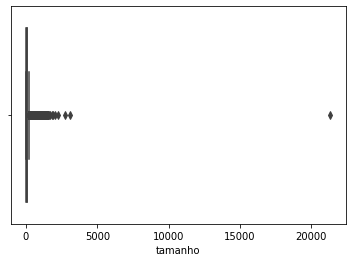

In [5]:
discursos['tamanho'] = discursos.tokens_.map(len)
sns.boxplot(discursos.tamanho) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


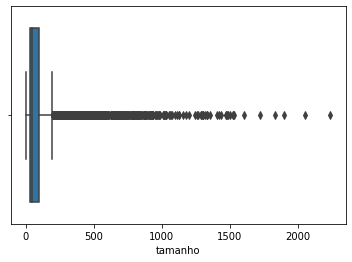

In [6]:
# descartar discursos muito grandes
MAX_TAM = 2500
discursos = discursos.loc[discursos.tamanho <= MAX_TAM]
sns.boxplot(discursos.tamanho)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


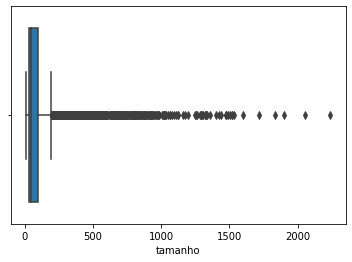

In [7]:
# descartar discursos muito curtos
MIN_TAM = 10
discursos = discursos.loc[discursos.tamanho >= MIN_TAM]
sns.boxplot(discursos.tamanho)

## Ajustando as classes

In [8]:
discursos.espectro.value_counts()

esquerda            24435
direita             14079
centro               7120
centro-direita       4225
extrema-esquerda     3941
centro-esquerda      3477
extrema-direita       894
indefinido             33
Name: espectro, dtype: int64

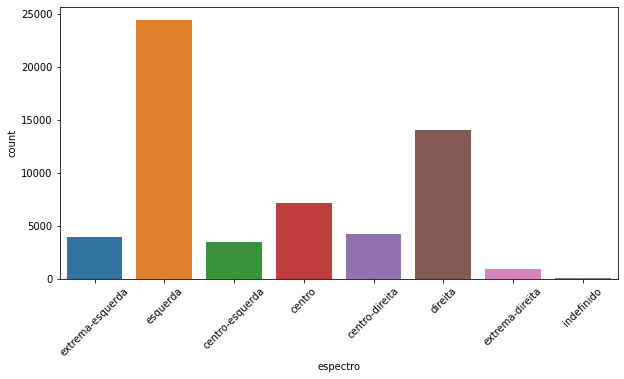

In [9]:
fig = plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.countplot(x = 'espectro' , data = discursos, order=ESPECTROS)
plt.show()

In [10]:
def ajusta_classe(espectro):

  if espectro == 'extrema-esquerda':
    return 'esquerda'

  if espectro == 'extrema-direita':
    return 'direita'

  if 'centro' in espectro:
    return 'centro'

  return espectro

discursos_ = discursos.copy()
discursos_.espectro = discursos_.espectro.replace('indefinido', None).dropna()

# discursos_.espectro = discursos_.espectro.map(ajusta_classe)

# ESPECTROS = ('esquerda', 'não-esquerda')
ESPECTRO_ALVO = 'todos'

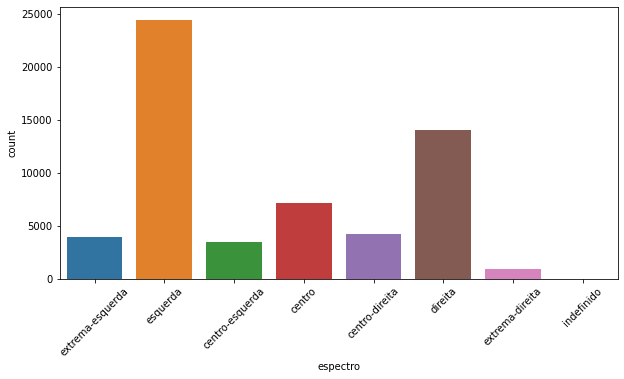

In [11]:
fig = plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.countplot(x = 'espectro', data = discursos_, order=ESPECTROS)
plt.show()

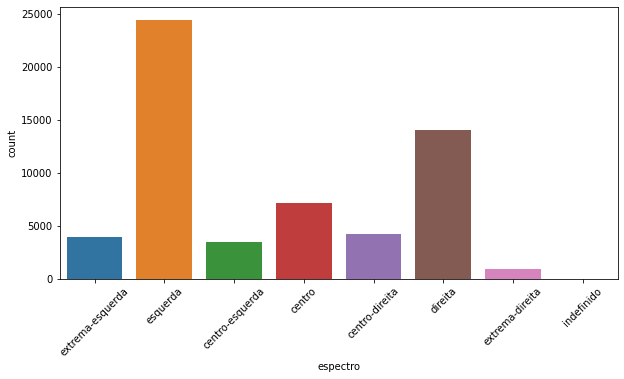

In [12]:
# rus = RandomUnderSampler(random_state=RANDOM_SEED)
# discursos_, y = rus.fit_resample(discursos_, discursos_['espectro'])

plt.figure(figsize=(10, 5))
plt.xticks(rotation=45)
sns.countplot(x = 'espectro' , data = discursos_, order=ESPECTROS)
plt.show()

In [13]:
df_treino, df_teste = train_test_split(discursos_, test_size=TEST_SIZE, random_state=RANDOM_SEED)

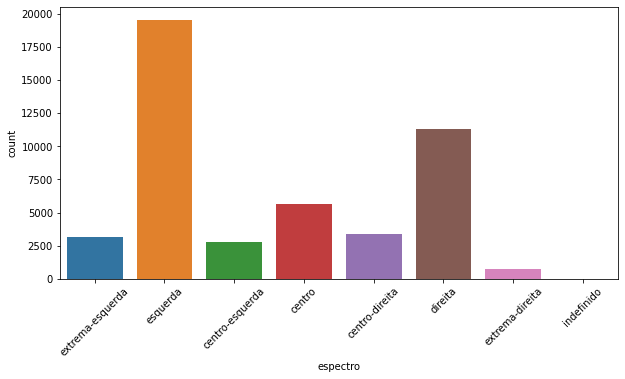

In [14]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
sns.countplot(x = 'espectro' , data = df_treino, order=ESPECTROS)
plt.show()

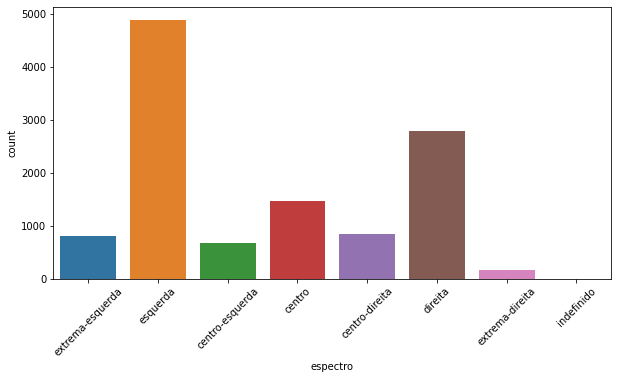

In [15]:
plt.figure(figsize=(10,5))
plt.xticks(rotation=45)
sns.countplot(x = 'espectro' , data = df_teste, order=ESPECTROS)
plt.show()

In [16]:
tokenizer = text.Tokenizer(num_words=MAX_FEATURES)
tokenizer.fit_on_texts(discursos_['tokens'])

labeler = LabelEncoder()
labeler.fit(discursos_['espectro'])

LabelEncoder()

In [17]:
# discursos = None
# detalhes = None

In [18]:
X_treino = df_treino['tokens']
X_teste = df_teste['tokens']

MAX_DOC_LEN = np.max((X_teste.map(len).max(), X_treino.map(len).max()))

X_treino = tokenizer.texts_to_sequences(X_treino)
X_treino = sequence.pad_sequences(X_treino, maxlen=MAX_DOC_LEN)

X_teste = tokenizer.texts_to_sequences(X_teste)
X_teste = sequence.pad_sequences(X_teste, maxlen=MAX_DOC_LEN)

In [19]:
Y_treino = df_treino['espectro']
Y_teste = df_teste['espectro']

Y_treino = to_categorical(labeler.transform(Y_treino), 7, dtype='float32')
Y_teste = to_categorical(labeler.transform(Y_teste), 7, dtype='float32')

In [20]:
w2v = Word2Vec.load(ROOTDIR + f'camares.{EMBEDDINGS_DIM}.w2v')

embeddings_mean, embeddings_std = w2v.wv.vectors.mean(), w2v.wv.vectors.std()

embeddings_matrix = np.random.normal(embeddings_mean, embeddings_std, size=(MAX_FEATURES, EMBEDDINGS_DIM))

for word, i in tokenizer.word_index.items():
    if i >= MAX_FEATURES: continue
    try:
      embeddings_matrix[i] = w2v.wv[word]
    except KeyError:
      pass

In [21]:
BATCH_SIZE = 200
EPOCHS = 250
PATIENCE_LR = 10
PATIENCE_ES = 5
FACTOR = 0.25
MIN_LR = 0.00000001
PLATEAU_MONITOR = 'val_categorical_crossentropy'
# PLATEAU_MONITOR = 'val_categorical_accuracy'
LSTM_LAYER1_SIZE = 32
LSTM_LAYER2_SIZE = 32
LAYER1_DROPOUT_RATE = 0.5
LAYER2_DROPOUT_RATE = 0.25
RECURRENT_DROPOUT_RATE = 0.2
DENSE_LAYER1_SIZE = 16
# DENSE_LAYER1_DROPOUT_RATE = 0.5
DENSE_LAYER2_SIZE = 16
# DENSE_LAYER2_DROPOUT_RATE = 0.25
DENSE_LAYER1_FUNCTION = 'relu'
DENSE_LAYER2_FUNCTION = 'relu'
OUTPUT_LAYER_SIZE = 7
OUTPUT_LAYER_FUNCTION = 'softmax'
LEARNING_RATE = 0.01
OPTIMIZER = tensorflow.keras.optimizers.Adam
LOSS_FUNCTION = 'categorical_crossentropy'
METRIC_FUNCTIONS = ['categorical_accuracy', 'categorical_crossentropy']
# VALIDATION_SPLIT_RATE = 0.2
VALIDATION_SPLIT_RATE = 0.1

model = Sequential()
# INPUT
model.add(Embedding(MAX_FEATURES, output_dim = EMBEDDINGS_DIM, weights = [embeddings_matrix], input_length = MAX_DOC_LEN, trainable = True))
# LSTM 
model.add(LSTM(units = LSTM_LAYER1_SIZE, return_sequences = True,  dropout = LAYER1_DROPOUT_RATE))
model.add(LSTM(units = LSTM_LAYER2_SIZE, recurrent_dropout = RECURRENT_DROPOUT_RATE, dropout = LAYER2_DROPOUT_RATE))
model.add(Dense(units = DENSE_LAYER1_SIZE, activation = DENSE_LAYER1_FUNCTION))
# model.add(Dropout(DENSE_LAYER1_DROPOUT_RATE))
model.add(Dense(units = DENSE_LAYER2_SIZE, activation = DENSE_LAYER2_FUNCTION))
# model.add(Dropout(DENSE_LAYER2_DROPOUT_RATE))
model.add(Dense(units = OUTPUT_LAYER_SIZE, activation = OUTPUT_LAYER_FUNCTION))
model.compile(optimizer = OPTIMIZER(learning_rate = LEARNING_RATE), loss = LOSS_FUNCTION, metrics = METRIC_FUNCTIONS)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8921, 100)         5000000   
                                                                 
 lstm (LSTM)                 (None, 8921, 32)          17024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 7)                 119       
                                                                 
Total params: 5,026,263
Trainable params: 5,026,263
Non-

In [ ]:
callbacks = [
  ReduceLROnPlateau(monitor = PLATEAU_MONITOR, patience = PATIENCE_LR, verbose = 2, factor = FACTOR, min_lr = MIN_LR),
  EarlyStopping(patience = PATIENCE_ES, verbose = True)             
]

if not os.path.isfile(ROOTDIR + f'classificador_discurso_espectro_{LEGISLATURA}_{ESPECTRO_ALVO}.dat'):

  history = model.fit(X_treino, Y_treino, batch_size = BATCH_SIZE, validation_split = VALIDATION_SPLIT_RATE, epochs = EPOCHS, callbacks = callbacks)

  with open(ROOTDIR + f'classificador_discurso_espectro_{LEGISLATURA}_{ESPECTRO_ALVO}.dat', 'wb') as fp:
    pickle.dump(model, fp)

  df_history = pd.DataFrame(history.history)
  df_history.to_json(ROOTDIR + f'data/history_classificador_discurso_espectro_{LEGISLATURA}_{ESPECTRO_ALVO}.json')


else:

  with open(ROOTDIR + f'classificador_discurso_espectro_{LEGISLATURA}_{ESPECTRO_ALVO}.dat', 'rb') as fp:
    model = pickle.load(fp)

  df_history = pd.read_json(ROOTDIR + f'data/history_classificador_discurso_espectro_{LEGISLATURA}_{ESPECTRO_ALVO}.json')

Epoch 1/250
210/210 [==============================] - 6204s 30s/step - loss: 1.4895 - categorical_accuracy: 0.4460 - categorical_crossentropy: 1.4895 - val_loss: 1.2986 - val_categorical_accuracy: 0.5285 - val_categorical_crossentropy: 1.2986 - lr: 0.0100
Epoch 2/250
210/210 [==============================] - 6316s 30s/step - loss: 1.1554 - categorical_accuracy: 0.5882 - categorical_crossentropy: 1.1554 - val_loss: 1.0023 - val_categorical_accuracy: 0.6435 - val_categorical_crossentropy: 1.0023 - lr: 0.0100
Epoch 3/250
210/210 [==============================] - 6385s 30s/step - loss: 0.9838 - categorical_accuracy: 0.6508 - categorical_crossentropy: 0.9838 - val_loss: 0.9326 - val_categorical_accuracy: 0.6682 - val_categorical_crossentropy: 0.9326 - lr: 0.0100
Epoch 4/250
210/210 [==============================] - 6439s 31s/step - loss: 0.9291 - categorical_accuracy: 0.6699 - categorical_crossentropy: 0.9291 - val_loss: 0.8933 - val_categorical_accuracy: 0.6824 - val_categorical_crosse

In [ ]:
ax = df_history[['val_loss', 'loss']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

ax = df_history[['val_categorical_accuracy', 'categorical_accuracy']].plot(figsize=(10, 5))
df_history['lr'].plot(ax=ax.twinx(), color='gray')

print("Acuracia de treinamento: {:.2f} %".format(model.evaluate(X_treino, Y_treino)[1]*100))
print("Acuracia de teste: {:.2f} %".format(model.evaluate(X_teste, Y_teste)[1]*100))

In [ ]:
previsto = np.argmax(model.predict(X_teste[0:]), axis=1)

In [ ]:
previsto

In [ ]:
real = np.argmax(Y_teste[0:], axis=1)

In [ ]:
real

In [ ]:
cm = confusion_matrix(real, previsto)
labels = labeler.classes_
cm = pd.DataFrame(cm, index = labels, columns = labels)

plt.figure(figsize = (10, 10))
sns.heatmap(cm, cmap= "Oranges", linecolor = 'black', linewidth = 1, annot = True, fmt='', xticklabels = labels, yticklabels = labels)
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()